TODO: do supervised learning to predict "success", where success is measured by further interaction by user.  Could
set a threshold and ocnvert to "sucess" or "fail" and then build a nn to predict whether a query will be successful or not.
If not, then could provide recs that correspond to nearest successful cluster

# Clustering user queries using Fashion CLIP embeddings

### Introduction

Start with csv of queries and filters: /Users/mingham/research/workspaces/search_and_recs/cache/series_queries.csv

see clustering_queries.ipynb for how these were loaded

In [19]:
# !pip install --no-binary snowflake-connector-python --force-reinstall "https://github.com/iserko/snowflake-connector-python/archive/refs/heads/SNOW-XXXXXX_wait_for_url_input_after_sso.zip#egg=snowflake-connector-python[secure-local-storage]" -q
# !pip install --user annoy
# !pip install transformers
import os
import pandas as pd
import snowflake.connector
import traceback
import matplotlib.pyplot as plt
import pickle
import numpy as np
import ast
import torch
import requests
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import sklearn as sk
from pathlib import Path
from io import BytesIO
from transformers import AutoProcessor, AutoModel, AutoTokenizer, CLIPTextModelWithProjection 
from typing import Callable, Dict, Iterator
# from PIL import Image
# from annoy import AnnoyIndex
# from torchvision import transforms
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from importlib import reload

import pydqt
# set workspace
pydqt.set_workspace('/Users/mingham/research/workspaces/','search_and_recs')

# import local embeddings code
import sys
sys.path.append('../src/')
import embeddings
import clustering as clustering

queries_csv = '/Users/mingham/research/workspaces/search_and_recs/cache/series_queries.csv'


### Calculate embeddings of queries using the Fashion CLIP model

embeddings are calculated by a python module, embeddings.py, which I run to produce csv files of embeddings:

python /Users/mingham/research/src/embeddings.py --number_of_runs=50 --chunk_size=200 --epochs=5


In [15]:
embeddings_path = '/Users/mingham/research/src'
embedding_idx = 0
embeddings_df = pd.read_csv(f'{embeddings_path}/embeddings_{embedding_idx}.csv')
# embeddings2_df, column_names = clustering.create_ortho_embeddings(embeddings_df)

In [16]:
embeddings_df

,query,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_503,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,feature_512
0,arcteryx,-0.395560,-0.262860,-0.284100,0.011488,0.076927,0.110884,-0.285859,-0.326531,0.206412,...,-0.090949,-0.385271,0.618263,0.254585,-0.120005,0.444667,-0.412261,0.316306,0.152145,0.313028
1,maxi dresses,0.143916,0.229968,-0.115475,-0.314809,-0.458020,-0.212207,0.135059,-0.199067,-0.210132,...,-0.515929,0.213758,-0.092813,0.306110,-0.547499,0.096689,0.120332,-0.086583,-0.293282,-0.027134
2,ombre,-0.042962,-0.105800,-0.312130,-0.075232,0.104917,-0.682406,0.211086,0.011595,-0.509873,...,0.490269,0.496583,0.007607,0.167649,0.256382,-0.256495,-0.144386,0.114731,-0.054913,-0.113850
3,leather men watches,-0.199659,-0.196586,-0.317964,-0.056889,-0.154712,0.193010,-0.540888,0.230961,0.236104,...,0.241771,0.019140,0.169263,0.186371,-0.234857,-0.209304,-0.567151,0.335694,0.112867,0.039943
4,veja sneakers,-0.665682,0.027221,0.017952,0.090470,0.412678,0.116795,0.288420,0.510706,-0.261173,...,0.203052,-0.389767,-0.063641,0.221538,0.120219,0.321691,0.118836,0.817288,0.120002,0.386504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9795,gucci sunglasses man men sunglasses,-0.069499,-0.178276,-0.364105,0.426969,0.267143,-0.290689,-0.000035,-0.055167,0.051008,...,0.329012,-0.282919,-0.073627,0.155520,0.242745,0.507153,-0.033691,0.327406,0.048072,0.426959
9796,adidas campus women sneakers shoes,-0.223716,-0.167532,0.225512,0.047612,0.103533,-0.321556,-0.246503,0.331763,-0.064343,...,0.317382,-0.126430,-0.010789,0.008653,0.397690,0.265546,-0.342552,0.471020,-0.201314,0.219704
9797,adidas campus women,-0.040021,-0.172015,0.192343,-0.018888,-0.031713,-0.303292,-0.269734,0.195173,-0.140023,...,0.287538,-0.090998,0.056182,0.011296,0.328406,0.265950,-0.304207,0.550052,-0.264351,0.275440
9798,sweater men,-0.189443,-0.129660,-0.571684,0.249088,0.131924,-0.470789,-0.082491,-0.331884,-0.233539,...,0.260300,-0.187784,0.202512,0.241303,0.326814,0.273237,0.072943,0.162269,-0.007796,-0.215523


Let's create a pipeline to handle standardisation and add dimensionality reduction.  Silhouette scores naturally decline in higher dimensional space

In [22]:
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA


class Settings:
    n_components = 10
    n_clusters = 15
    random_state = 42
    def __repr__(self):
        return f"""
    settings:
        n_components:   {self.n_components}
        n_clusters:     {self.n_clusters}
        random_state:   {self.random_state}
    """    
settings = Settings()


columns = [x for x in embeddings_df.columns if x!='query']
data = embeddings_df[columns].to_numpy()



In [24]:
# do all PCs here so we can examine variance
process_pipe = make_pipeline(
    Normalizer(),
    # PCA(n_components=settings.n_components, random_state=settings.random_state)
    PCA(random_state=settings.random_state)    
)
pipe = Pipeline([
    ('process',process_pipe),
    ('kmeans', KMeans(
               n_clusters=settings.n_clusters,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=settings.random_state,
        )
     )
])




pipe.fit(data)
# pipe["process"]["normalizer"].transform(data)
# pipe["kmeans"].labels_
# x=pipe["process"].transform(data)

Pipeline(steps=[('process',
                 Pipeline(steps=[('normalizer', Normalizer()),
                                 ('pca', PCA(random_state=42))])),
                ('kmeans',
                 KMeans(max_iter=500, n_clusters=15, n_init=50,
                        random_state=42))])

#### PCA Pareto PLot - top 100 components make up 80% of variance

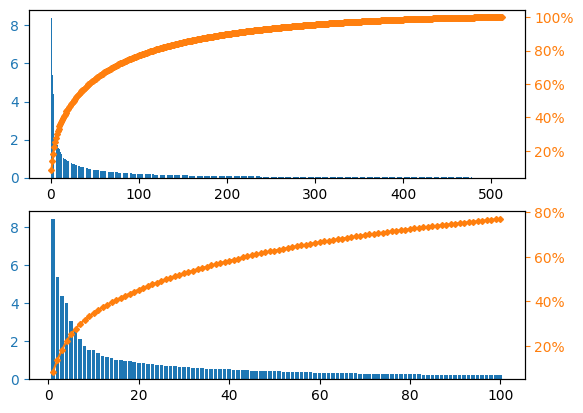

In [25]:
from matplotlib.ticker import PercentFormatter

pc_df = pd.DataFrame({'pct':100*pipe["process"]['pca'].explained_variance_ratio_})
pc_df['cumpct'] = pc_df["pct"].cumsum()/pc_df["pct"].sum()*100

pc_df.index = pc_df.index+1

fig, (ax, ax1) = plt.subplots(nrows=2)

# top plot
ax.bar(pc_df.index, pc_df["pct"], color="C0")
ax2 = ax.twinx()
ax2.plot(pc_df.index, pc_df["cumpct"], color="C1", marker="D", ms=3)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")

# bottom (zoomed) plot
pc_df2 = pc_df.iloc[0:100]
ax1.bar(pc_df2.index, pc_df2["pct"], color="C0")
ax12 = ax1.twinx()
ax12.plot(pc_df2.index, pc_df2["cumpct"], color="C1", marker="D", ms=3)
ax12.yaxis.set_major_formatter(PercentFormatter())
ax1.tick_params(axis="y", colors="C0")
ax12.tick_params(axis="y", colors="C1")

plt.show()


### Silhouette Scores are inversely proportional to dimensionality, whereas inertia scales with dimensionality

In [149]:
# pipe.get_params().keys()
hyperparameters = { 
    'process__pca__n_components': np.arange(20,520,20),
    'kmeans__n_clusters': np.arange(10,110,10)
}
# clusters = [5,7,10,20,30]
# clusters=np.arange(10,110,10)
clusters = np.array([10, 20])
components = np.arange(20,220,20)
components = np.concatenate((np.array([5,10]),components))
silhouette_array = np.zeros(shape=(clusters.shape[0], components.shape[0]))
inertia_array = np.zeros(shape=(clusters.shape[0], components.shape[0]))
for i,n_cluster in enumerate(clusters):
    for j,n_component in enumerate(components):
        pipe.set_params(process__pca__n_components=n_component, kmeans__n_clusters=n_cluster).fit(data)        
        preprocessed_data = pipe["process"].transform(data)
        predicted_labels = pipe["kmeans"].labels_
        inertia=pipe["kmeans"].inertia_
        inertia_array[i,j] = inertia
        print(f'inertia for {n_cluster} clusters and {n_component} components = {inertia}')
        sc=silhouette_score(preprocessed_data, predicted_labels)
        silhouette_array[i,j]=sc
        print(f'silhouette score for {n_cluster} clusters and {n_component} components = {sc}')



inertia for 10 clusters and 5 components = 350.33435888288574
silhouette score for 10 clusters and 5 components = 0.33370746064744167
inertia for 10 clusters and 10 components = 742.6859711137886
silhouette score for 10 clusters and 10 components = 0.25838752061259057
inertia for 10 clusters and 20 components = 1292.3287376343856
silhouette score for 10 clusters and 20 components = 0.18388495900023358
inertia for 10 clusters and 40 components = 1977.1255718695752
silhouette score for 10 clusters and 40 components = 0.13309091971567408
inertia for 10 clusters and 60 components = 2414.344771942984
silhouette score for 10 clusters and 60 components = 0.10599822513463453
inertia for 10 clusters and 80 components = 2730.2953711284613
silhouette score for 10 clusters and 80 components = 0.09503046378807342
inertia for 10 clusters and 100 components = 2974.3293911349847
silhouette score for 10 clusters and 100 components = 0.08200918433180877
inertia for 10 clusters and 120 components = 3166.

Text(0, 0.5, 'Average silhouette score')

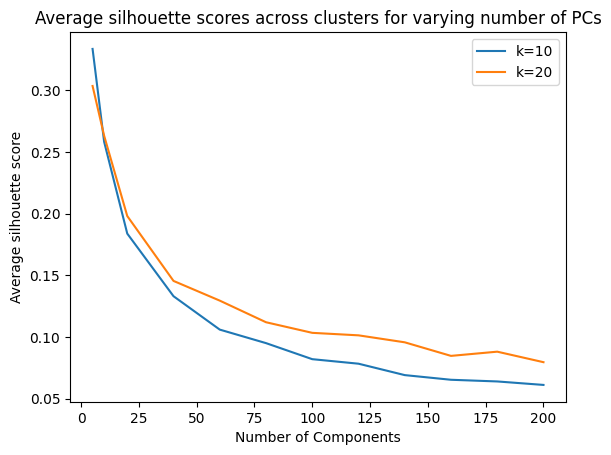

In [153]:

df = pd.DataFrame(silhouette_array).transpose()
df.columns = ['k=10', 'k=20']
df.index=components
ax = df.plot(title='Average silhouette scores across clusters for varying number of PCs')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Average silhouette score')

In [154]:
df

,k=10,k=20
5,0.333707,0.303643
10,0.258388,0.263278
20,0.183885,0.198139
40,0.133091,0.145500
60,0.105998,0.129512
80,0.095030,0.111974
100,0.082009,0.103372
120,0.078339,0.101348
140,0.069081,0.095687
160,0.065301,0.084677


Text(0, 0.5, 'Inertia')

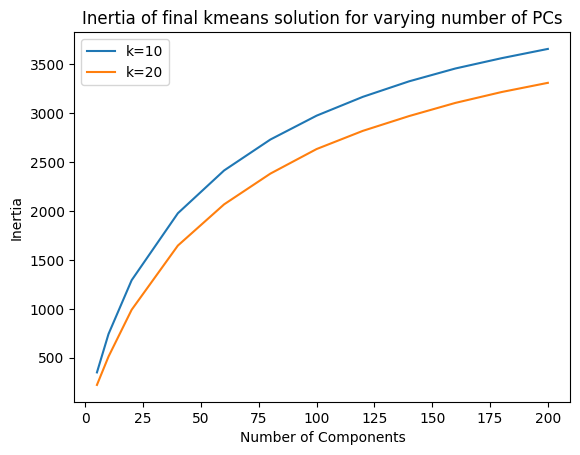

In [199]:
inertia_df = pd.DataFrame(inertia_array).transpose()
inertia_df.columns = ['k=10', 'k=20']
inertia_df.index=components
ax = inertia_df.plot(title='Inertia of final kmeans solution for varying number of PCs')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Inertia')

#### There is a trade-off to be made between how well clusters fit and loss of information (as measured by variance explained)

<Axes: xlabel='silhouette', ylabel='pct_explained'>

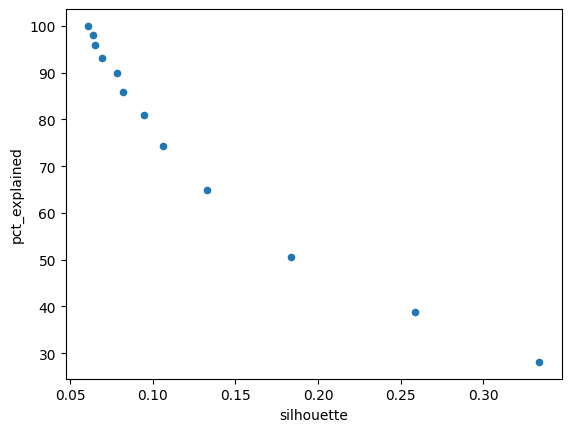

In [172]:
df_scatter = pd.DataFrame({'silhouette': df['k=10'], 'pct_explained':pc_df.loc[df.index]['cumpct']})
df_scatter.plot(kind='scatter',x='silhouette',y='pct_explained')
# df_scatter.plot(kind='scatter')
# df['k=10']

# pc_df.loc[df.index]['cumpct']

Recap: we're not trying to build the best cluster model or explain the maximum amount of variance across embeddings.  We're trying to assess the recommendations presented to a user, given their query.  If we can identify clusters we trust then we might gain an insight into we're our recommendations do well and where they don't.

k=10, #PC=10 gives an average silouette of c.0.3.  Let's take a look at individual clusters

For n_clusters = 10 The average silhouette_score is : 0.25840946397363845
For n_clusters = 20 The average silhouette_score is : 0.2568219207115889
For n_clusters = 50 The average silhouette_score is : 0.23055227167637427
For n_clusters = 100 The average silhouette_score is : 0.21745578682939817


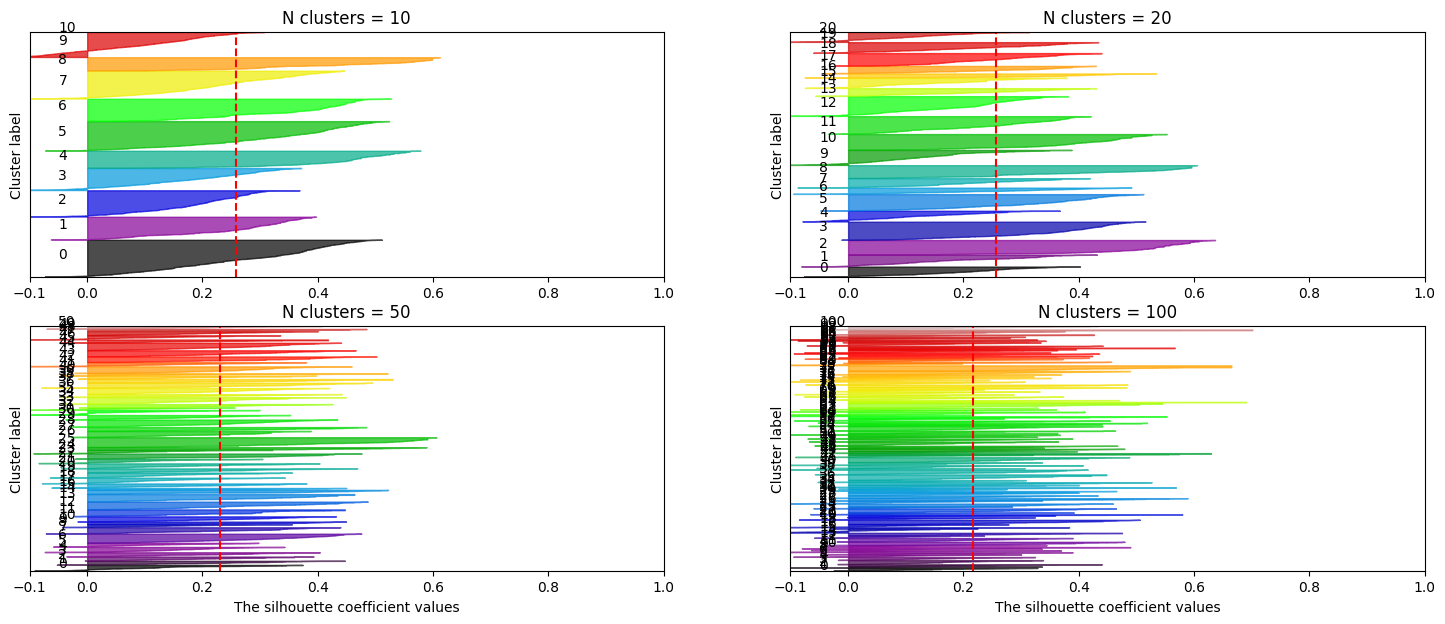

In [184]:
import clustering as c
reload(c)
# from clustering import plot_silhouettes

n_component=10
pipe.set_params(process__pca__n_components=n_component)
preprocessed_data = pipe["process"].transform(data)

c.plot_silhouettes(preprocessed_data, clusters=[10,20,50,100,200])


For n_clusters = 2 The average silhouette_score is : 0.18962352298889146
For n_clusters = 4 The average silhouette_score is : 0.20176662038630047
For n_clusters = 6 The average silhouette_score is : 0.20947041328743835
For n_clusters = 8 The average silhouette_score is : 0.24487376717270834


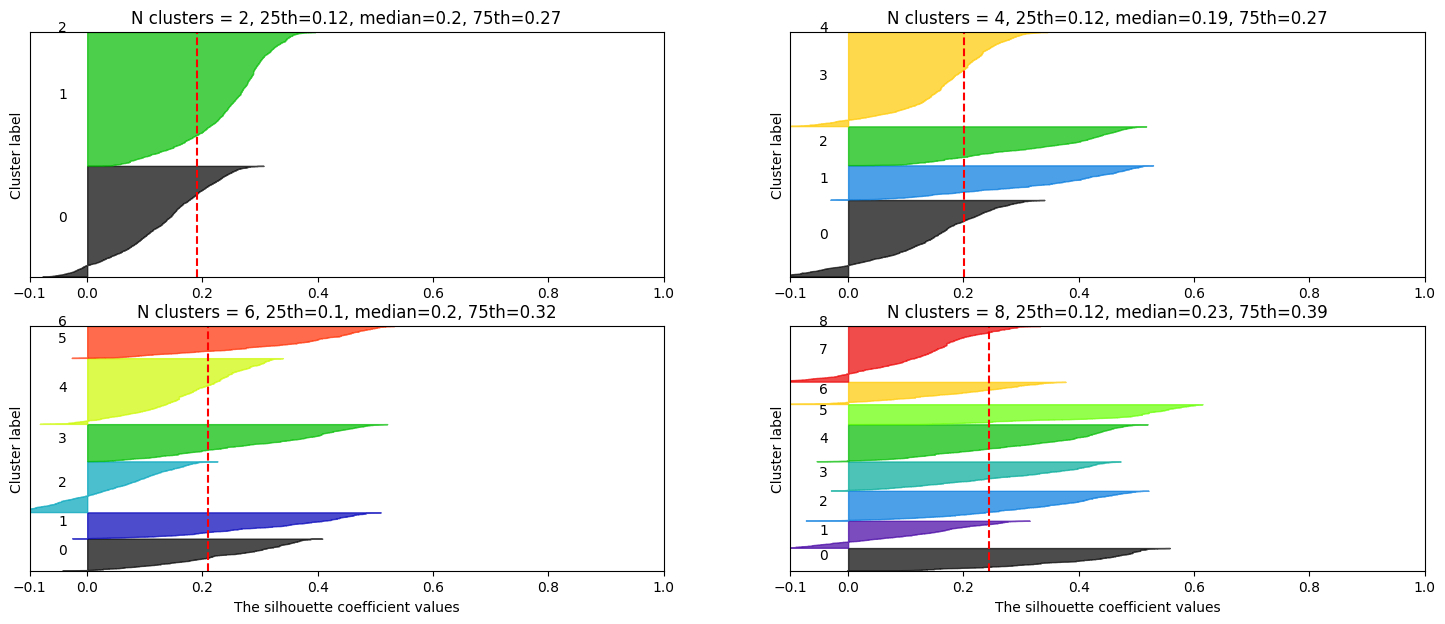

In [207]:
c.plot_silhouettes(preprocessed_data, clusters=[2,4,6,8])

For n_clusters = 10 The average silhouette_score is : 0.25840946397363845
For n_clusters = 15 The average silhouette_score is : 0.26499333105152806
For n_clusters = 20 The average silhouette_score is : 0.2568219207115889
For n_clusters = 30 The average silhouette_score is : 0.2543975473922121


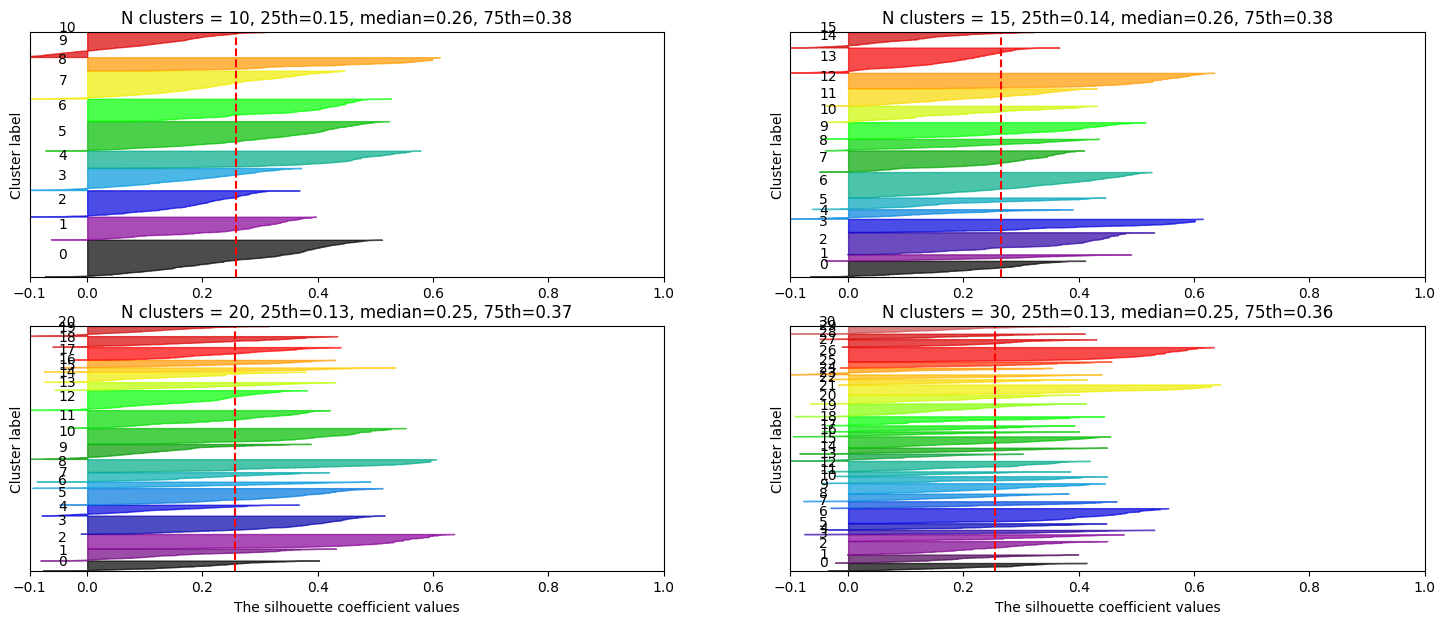

In [198]:
reload(c)
c.plot_silhouettes(preprocessed_data, clusters=[10,15, 20, 30])

Let's look inside some clusters for PCs=10, k=15

In [38]:
# create dict with cluster_labels as key and array of queries as values

n_component=10
n_cluster=15

pipe.set_params(process__pca__n_components=n_component, kmeans__n_clusters=n_cluster).fit(data)
predicted_labels = pipe["kmeans"].labels_


cluster_indices = [x for x in range(0,n_cluster)]
cluster_dict = {}
cluster_df=pd.DataFrame()
def get_indices(x,n):
    i=[]
    for idx, val in enumerate(x):
        if val==n:
            i.append(idx)
    return i
for cluster_idx in cluster_indices:   
    cluster_dict[cluster_idx] = pd.Series(embeddings_df.iloc[get_indices(predicted_labels, cluster_idx)]['query'].unique())
for key, val in cluster_dict.items():
    cluster_df = pd.concat([cluster_df.reset_index(drop=True), val[lambda x: x != ''].reset_index(drop=True).rename(f'cluster_{key}')], axis=1)    

cluster_df.to_csv(f'/Users/mingham/research/clusters_pc{n_component}_k{n_cluster}.csv')    

In [241]:
cluster_dict[8]

0                             jacquemus bags
1                           prada women bags
2                             longchamp bags
3                                 prada bags
4                      loro piana women bags
                       ...                  
378                           dior bag women
379    coach saddle women shoulder+bags bags
380                        micheal kors bags
381          tumi leather men backpacks bags
382            gucci bamboo women totes bags
Length: 383, dtype: object

In [219]:
cluster_dict[12]

5              dolce gabanna women dresses
29                          max mara coats
43               magda butrym bikini women
60                     massimo dutti women
138               acne studios scarf women
                       ...                
9712                           fendi skirt
9744                     reiss nina skirts
9755    g star raw 3301 skinny women jeans
9774                    rixo women dresses
9780           ralph lauren sudadera women
Name: query, Length: 384, dtype: object